In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-for-collaborative-filters/songsDataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/dataset-for-collaborative-filters/songsDataset.csv")

In [3]:
df['user_id'] = df["'userID'"]
df['song_id'] = df["'songID'"]
df['rating'] = df["'rating'"]
df.drop(["'userID'", "'songID'", "'rating'"], axis=1, inplace=True)
df

,user_id,song_id,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5
...,...,...,...
1999995,199999,75840,2
1999996,199999,85921,1
1999997,199999,116763,1
1999998,199999,128758,1


In [4]:
import tensorflow as tf

2024-06-07 12:04:28.740658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 12:04:28.740824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 12:04:28.904505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
unique_user_cnt = len(df['user_id'].unique())
unique_song_cnt = len(df['song_id'].unique())
print(unique_song_cnt, unique_user_cnt, unique_song_cnt*unique_user_cnt)

127771 200000 25554200000


In [6]:
# count is being reduced to faster the training process
song_ids_to_be_taken = 10000
user_ids_to_be_taken = 10000
filtered_df = df[(df.user_id <= user_ids_to_be_taken) & (df.song_id <= song_ids_to_be_taken)]


In [7]:
no_of_user_ids = filtered_df['user_id'].max()
no_of_song_ids = filtered_df['song_id'].max()
print(no_of_user_ids, no_of_song_ids, no_of_song_ids*no_of_user_ids)
filtered_df

9999 9995 99940005


,user_id,song_id,rating
0,0,7171,5
1,0,8637,4
10,1,3342,5
11,1,7522,1
30,3,1666,1
...,...,...,...
99920,9992,1418,5
99930,9993,6301,5
99940,9994,5428,1
99990,9999,1666,5


In [8]:
#base matrix => mat - UV^T
indices = filtered_df[['user_id', 'song_id']].values
ratings = filtered_df['rating'].values
matrix = tf.SparseTensor(indices=indices, values=ratings, dense_shape=[10000, 10000])

In [9]:
embed_dim = 5
user_embed_shape = [10000, embed_dim]
song_embed_shape = [10000, embed_dim]



In [10]:
def cost_fun(W, A, B):
    """defines the cost function"""
    preds = tf.gather_nd(params=tf.matmul(A, B, transpose_b=True), 
                        indices=W.indices)
    loss =tf.keras.losses.MSE(W.values, preds)
    return loss

tf.random.set_seed(4)

In [11]:
user_embed_mat = tf.Variable(tf.random.normal(user_embed_shape, stddev=0.5, mean=0))
song_embed_mat = tf.Variable(tf.random.normal(song_embed_shape, stddev=0.5, mean=0))

In [12]:
class Model():
    def __init__(self, ratings_mat, embeddings, iterations, learning_rate, loss_fun, metrics=None):
        self.embeddings = embeddings
        self.learning_rate = learning_rate
        self.loss = loss_fun
        self.history = []
        self.iteration = iterations
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.ratings_mat = ratings_mat
    def embeddings(self):
        return self.embeddings
    def train(self):
        weights = [self.embeddings['user_embed'], self.embeddings['song_embed']]
        for i in range(self.iteration):
            with tf.GradientTape() as tape:
                train_loss_val = self.loss(self.ratings_mat, weights[0], weights[1])
                grads = tape.gradient(train_loss_val, weights)
                self.optimizer.apply_gradients(zip(grads, weights))
                if i%100:
                    print(f"train_loss : {train_loss_val}")
                
                if i%10:
                    self.history.append(train_loss_val)
        self.embeddings['user_embed'] = weights[0]
        self.embeddings['song_embed'] = weights[1]
    
    def training_plot(self):
        iterations =[ i*10 for i in enumerate(self.history)]
        plt.plot(iterations,self.history)
        plt.show()
    def predict(self, song_id=None, user_id=None):
        user_embed = self.embeddings['user_embed'][user_id]
        song_embed = self.embeddings['song_embed'][song_id]
        
        return tf.reduce_sum(user_embed*song_embed).numpy()
    
    def true_rating(self, song_idx, user_idx):
        sparse_slice = tf.sparse.slice(self.ratings_mat, [song_idx, user_idx], [1, 1])

        # Convert the slice to dense to access the value
        dense_slice = tf.sparse.to_dense(sparse_slice)

        # Assuming the slice contains a single value, extract it
        value = dense_slice.numpy()[0, 0]
        return value

    
    

In [13]:
# user_embed_mat == song_embed_mat
matrix.indices

<tf.Tensor: shape=(7375, 2), dtype=int64, numpy=
array([[   0, 7171],
       [   0, 8637],
       [   1, 3342],
       ...,
       [9994, 5428],
       [9999, 1666],
       [9999, 3047]])>

In [14]:
embeddings = {'user_embed': user_embed_mat, 'song_embed': song_embed_mat}
matrix_fact_model = Model(matrix, embeddings, 2000, 0.001, cost_fun)

In [15]:
matrix_fact_model.train()

train_loss : 14.928492546081543
train_loss : 14.90900707244873
train_loss : 14.889535903930664
train_loss : 14.870081901550293
train_loss : 14.8506498336792
train_loss : 14.831241607666016
train_loss : 14.811853408813477
train_loss : 14.792495727539062
train_loss : 14.773159980773926
train_loss : 14.753852844238281
train_loss : 14.734569549560547
train_loss : 14.715314865112305
train_loss : 14.696084976196289
train_loss : 14.676883697509766
train_loss : 14.657706260681152
train_loss : 14.638555526733398
train_loss : 14.619431495666504
train_loss : 14.600330352783203
train_loss : 14.581257820129395
train_loss : 14.562210083007812
train_loss : 14.543183326721191
train_loss : 14.52418327331543
train_loss : 14.505208969116211
train_loss : 14.486254692077637
train_loss : 14.467325210571289
train_loss : 14.44841480255127
train_loss : 14.42952823638916
train_loss : 14.410664558410645
train_loss : 14.39181900024414
train_loss : 14.372994422912598
train_loss : 14.354188919067383
train_loss : 14

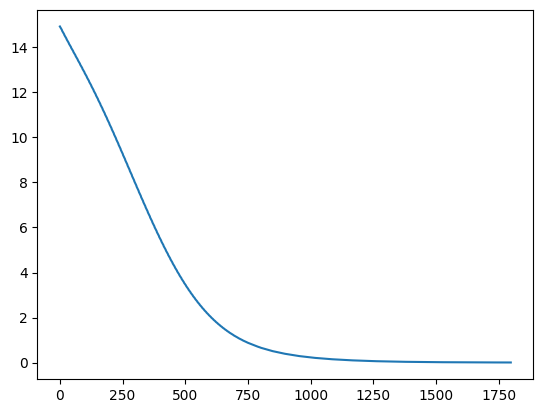

In [16]:
import matplotlib.pyplot as plt
history = [i.numpy() for i in matrix_fact_model.history]
x = [i[0] for i in enumerate(history)]
plt.plot(x, history)

In [17]:
matrix_fact_model.predict(7171, 0)

5.000117

In [18]:
matrix_fact_model.true_rating(0, 7171)

5

In [19]:
#over fitting has taken place